# Try out some classification models to classifying emotions
- classify happy, sad, others

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

# Load data and inspect

In [2]:
def load_face_data():
    notebook_dir = os.getcwd()
    os.chdir('../data/')
    df = pd.read_csv('icml_face_data.csv')
    os.chdir(notebook_dir)
    return df
df = load_face_data()

In [3]:
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


# Data cleaning

In [5]:
# strip spaces from column names and apply lower case
df = df.rename(columns={c:c.strip().lower() for c in df.columns})
print(df.columns)

Index(['emotion', 'usage', 'pixels'], dtype='object')


In [6]:
# convert pixels to array for ease in visualization and image preprocessing
def pixel_str_to_array(pixel_str):
    '''
    converts pixel as str separated by white spaces to an array
    '''
    pixel_array = np.array(pixel_str.split(), dtype=int)
    return pixel_array.reshape(48,48)

    
df['pixels_array'] = df['pixels'].apply(pixel_str_to_array)

In [7]:
# map emotion name
emotion_map = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
df['emotion_nm'] = df.emotion.map(emotion_map)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   emotion       35887 non-null  int64 
 1   usage         35887 non-null  object
 2   pixels        35887 non-null  object
 3   pixels_array  35887 non-null  object
 4   emotion_nm    35887 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.4+ MB


# EDA

## Look at sample images
- 48*48 pixels
- almost straight-faced, grayscale images

Showing random sample images for Angry


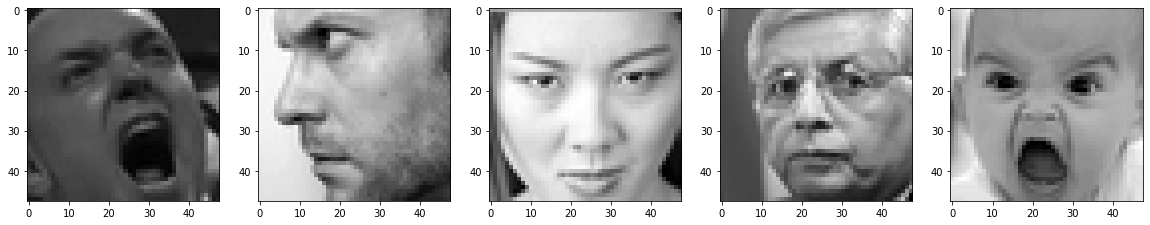

Showing random sample images for Disgust


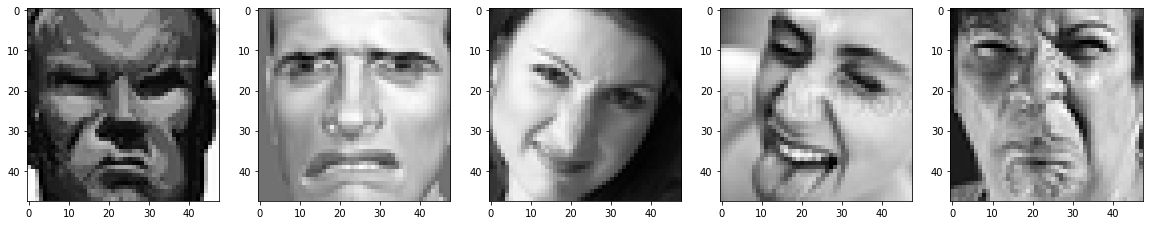

Showing random sample images for Fear


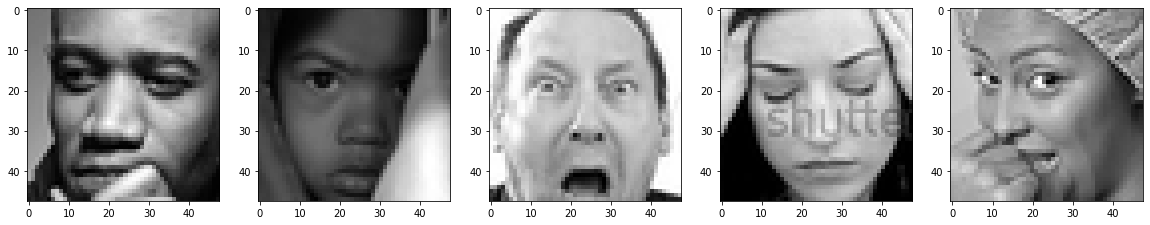

Showing random sample images for Happy


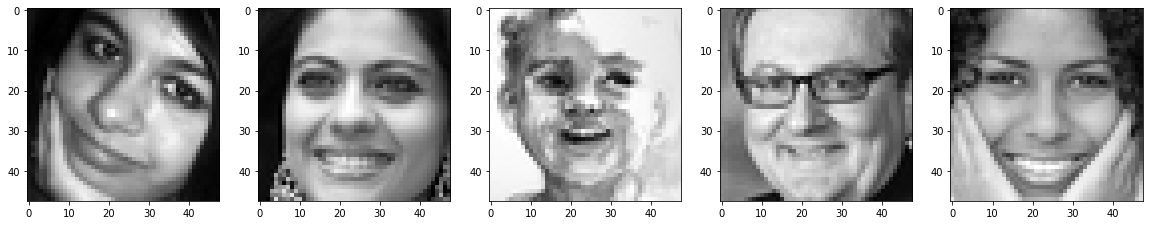

Showing random sample images for Neutral


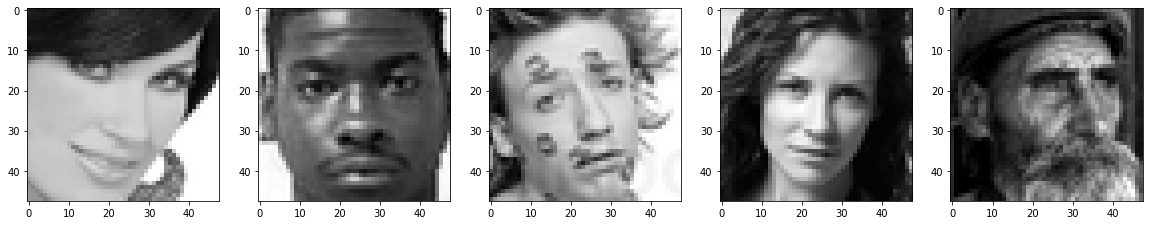

Showing random sample images for Sad


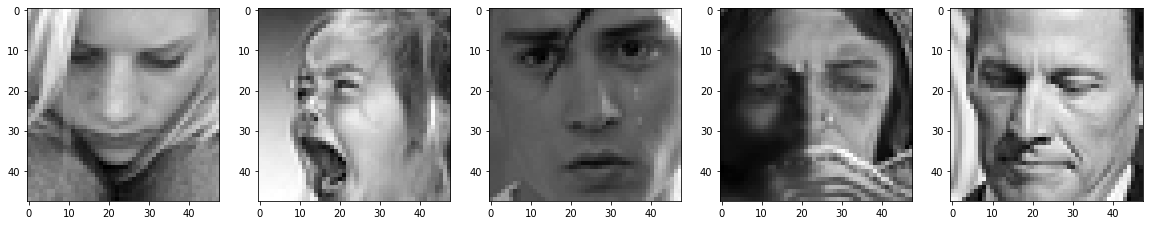

Showing random sample images for Surprise


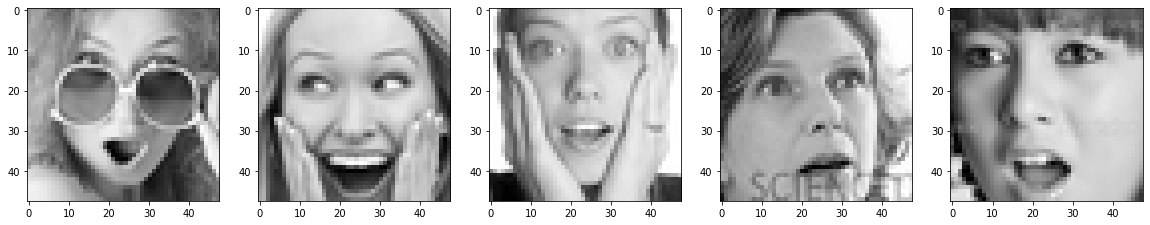

In [9]:
for emotion in sorted(df['emotion_nm'].unique()):
    print(f'Showing random sample images for {emotion}')
    n_sample = 5
    sample_imgs = df[df.emotion_nm == emotion]['pixels_array'].sample(5)
    fig, ax = plt.subplots(1, n_sample, figsize=(20,4))
    for i in range(n_sample):
        ax[i].imshow(sample_imgs.iloc[i], cmap='gray')
    plt.show()

## Emotion
- 'Disgust' has too few samples --> consider removing from model training

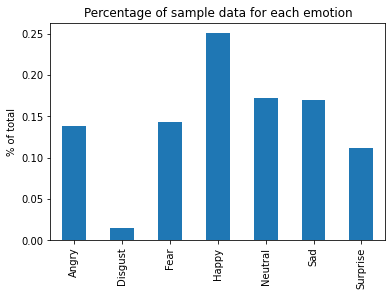

In [10]:
df['emotion_nm'].value_counts(normalize=True).sort_index().plot(kind='bar')
plt.ylabel('% of total')
plt.title('Percentage of sample data for each emotion')

plt.show()

## Usage type
- The training set consists of 28,709 examples.
- The public test set used for the leaderboard consists of 3,589 examples.
- The final test set, which was used to determine the winner of the competition, consists of another 3,589 examples.

- classes are distributed in the same manner in each usage

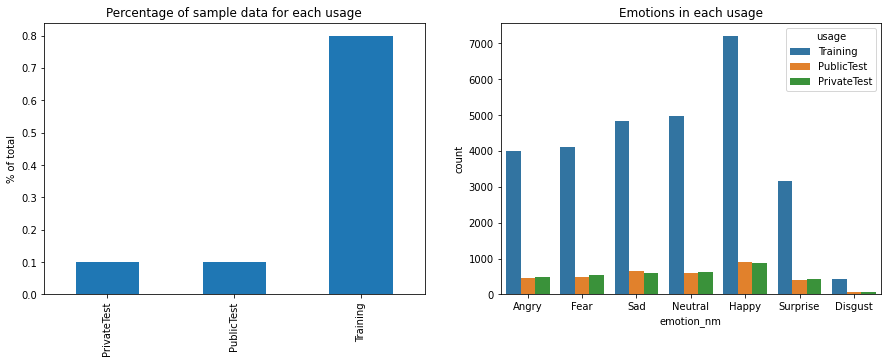

In [11]:
plt.figure(figsize=(15,5))

plt.subplot(121)
df['usage'].value_counts(normalize=True).sort_index().plot(kind='bar')
plt.ylabel('% of total')
plt.title('Percentage of sample data for each usage')

plt.subplot(122)
sns.countplot(data=df, x='emotion_nm', hue='usage')
plt.title('Emotions in each usage')

plt.show()

# Data preprocessing

In [12]:
# separate each pixel in pixels array to one column --> to be used as features to try our basic ML models
def pixels_str_to_X(df, pixels_col='pixels'):
    '''
    convert df column of pixel str to an array to be feed into the model

    returns:
    X - array of shape (n_records, 2304)
    '''
    X = []
    for pixel_str in df[pixels_col].values:
        X.append(np.array(pixel_str.split(), dtype=int))
    return np.array(X)

def pixels_array_to_X(df, pixels_array_col='pixels_array'):
    '''
    convert df column of pixel arrays to an array to be feed into the model
    
    Inputs:
    df - dataframe holding the column
    pixels_array_col - column name in the dataframe containing img as arrays

    returns:
    X - array of shape (df.shape[0], df[pixels_array_col].values[0].shape[0], df[pixels_array_col].values[0].shape[1]) 
    '''
    n_h_w = [df.shape[0], df[pixels_array_col].values[0].shape[0], df[pixels_array_col].values[0].shape[1]] # n records, height, width
    result = np.empty(tuple(n_h_w))
    for i in range(df.shape[0]):
        result[i] = df[pixels_array_col].values[i]
    return result.reshape(tuple(n_h_w + [1]))

def emotion_to_y(df, emotions_to_classify=[], emotion_col='emotion'):
    '''
    change emotion to assign variables we want to classify and others as 0
    ex: emotions_to_classify = ['Happy'] (ie. binary classification) 
    'Happy' will have the value of 1 
    the rest will have value of 0

    ex: emotions_to_classify = ['Happy', 'Fear']
    'Happy' will have the value of 1 
    'Fear' will have the value of 2
    the rest will have value of 0

    Inputs:
    df - dataframe holding the column
    emotion_col - column name in the dataframe containing emotion names
    emotions_to_classify - list of emotions to classify

    returns:
    y - array of target values
    '''
    # emotion_nm_to_target = {'Angry':0, 'Disgust':1, 'Fear':2, 'Happy':3, 'Sad':4, 'Surprise':5, 'Neutral':6}
    if not emotions_to_classify:
        return df[emotion_col].values
    else:
        emotion_map = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
        y = []
        for i in df[emotion_col].values:
            emotion_nm = emotion_map[i]
            if emotion_nm in emotions_to_classify:
                y.append(emotions_to_classify.index(emotion_nm) + 1)
            else:
                y.append(0)
        return np.array(y)


In [13]:
# focus on binary classification between Sad vs neutral
df_train = df[
    (df['emotion'].isin([4,6])) & 
    (df['usage'] == 'Training')
    ]

In [14]:
df_train.head()

,emotion,usage,pixels,pixels_array,emotion_nm
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,"[[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, ...",Sad
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,"[[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 2...",Neutral
6,4,Training,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,"[[20, 17, 19, 21, 25, 38, 42, 42, 46, 54, 56, ...",Sad
11,6,Training,39 75 78 58 58 45 49 48 103 156 81 45 41 38 49...,"[[39, 75, 78, 58, 58, 45, 49, 48, 103, 156, 81...",Neutral
12,6,Training,219 213 206 202 209 217 216 215 219 218 223 23...,"[[219, 213, 206, 202, 209, 217, 216, 215, 219,...",Neutral


## Features

In [15]:
# get X features array
X_train_skl = pixels_str_to_X(df_train) 
print(X_train_skl.shape)

(9795, 2304)


In [16]:
# get X features array
X_train = pixels_array_to_X(df_train) 
print(X_train.shape)

(9795, 48, 48, 1)


In [17]:
# calculate pixel-wise stats and define standardize function
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)

def standardize(x): 
    return (x-mean_px)/std_px

## Target

In [18]:
print(df_train['emotion_nm'].value_counts())
print(df_train['emotion_nm'].value_counts(normalize=True))

Neutral    4965
Sad        4830
Name: emotion_nm, dtype: int64
Neutral    0.506891
Sad        0.493109
Name: emotion_nm, dtype: float64


In [19]:
y_train_skl = df_train['emotion']

In [20]:
from keras.utils.np_utils import to_categorical

y_train = emotion_to_y(df_train, emotions_to_classify=['Sad'])
# y_train = to_categorical(y_train)

In [21]:
print(y_train.shape)

(9795,)


# Explore models

In [22]:
from keras.models import Sequential
from keras.layers import Lambda, Flatten
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D

from keras.callbacks import EarlyStopping

## KNN classifier

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

X_train_skl = StandardScaler().fit_transform(X_train_skl)
knn = KNeighborsClassifier().fit(X_train_skl, y_train_skl)

In [24]:
knn.score(X_train_skl, y_train_skl)

0.7354772843287392

## Linear classifier

In [27]:
def get_linear_clf():
    model = Sequential()
    
    model.add(Lambda(standardize,input_shape=(48,48,1)))
    model.add(Flatten())

    model.add(Dense(1, activation='softmax'))
 
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [28]:
linear_clf = get_linear_clf()
linear_clf.fit(X_train, y_train, validation_split=0.2, epochs=50, callbacks=[EarlyStopping(patience=3)])

Epoch 1/50
245/245 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.4921 - val_loss: 0.0000e+00 - val_accuracy: 0.4972
Epoch 2/50
245/245 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.4921 - val_loss: 0.0000e+00 - val_accuracy: 0.4972
Epoch 3/50
245/245 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.4921 - val_loss: 0.0000e+00 - val_accuracy: 0.4972
Epoch 4/50
245/245 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.4921 - val_loss: 0.0000e+00 - val_accuracy: 0.4972


## Neural network with fully-connected layers

In [29]:
def get_dense_clf():
    model = Sequential()
    
    model.add(Lambda(standardize,input_shape=(48,48,1)))
    model.add(Flatten())

    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    
    model.add(Dense(1, activation='softmax'))
 
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [30]:
dense_clf = get_dense_clf()
dense_clf.fit(X_train, y_train, validation_split=0.2, epochs=50, callbacks=[EarlyStopping(patience=3)])

Epoch 1/50
245/245 [==============================] - 1s 4ms/step - loss: 0.0000e+00 - accuracy: 0.4921 - val_loss: 0.0000e+00 - val_accuracy: 0.4972
Epoch 2/50
245/245 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.4921 - val_loss: 0.0000e+00 - val_accuracy: 0.4972
Epoch 3/50
245/245 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.4921 - val_loss: 0.0000e+00 - val_accuracy: 0.4972
Epoch 4/50
245/245 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.4921 - val_loss: 0.0000e+00 - val_accuracy: 0.4972


## CNN

In [ ]:
def get_cnn_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Convolution2D(32,(3,3), activation='relu'),
        Convolution2D(32,(3,3), activation='relu'),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='relu'),
        Convolution2D(64,(3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Data augmentation